# Neural Style Transfer

### Import libraries  

In [1]:
from PIL import Image
import numpy as np
from torchvision import transforms, models
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

### VVG19 Model

In [2]:
VGG_MODEL = models.vgg19(pretrained=True).features

for i in VGG_MODEL.parameters():
    i.requires_grad_(False)

In [3]:
DT = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VGG_MODEL.to(DT)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images

In [4]:
def Style_and_Content_Images_Loader(imagePATH, MSize=400, shape=None):
    image = Image.open(imagePATH).convert('RGB')
    if max(image.size) > MSize:
        SZ = MSize
    else:
        SZ = max(image.size)
        
    if shape is not None:
        SZ = shape
    tf = transforms.Compose([
                        transforms.Resize(SZ),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])
    image = tf(image)[:3,:,:].unsqueeze(0)
    return image

In [5]:
contentImage = Style_and_Content_Images_Loader('content images/Satoru.jpg').to(DT)
styleImage = Style_and_Content_Images_Loader('Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2786.jpg', shape=contentImage.shape[-2:]).to(DT)

In [6]:
def Conv_IMG(tensor):
    img = tensor.to("cpu").clone().detach()
    img = img.numpy().squeeze()
    img = img.transpose(1,2,0)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    img = img.clip(0, 1)
    
    return img

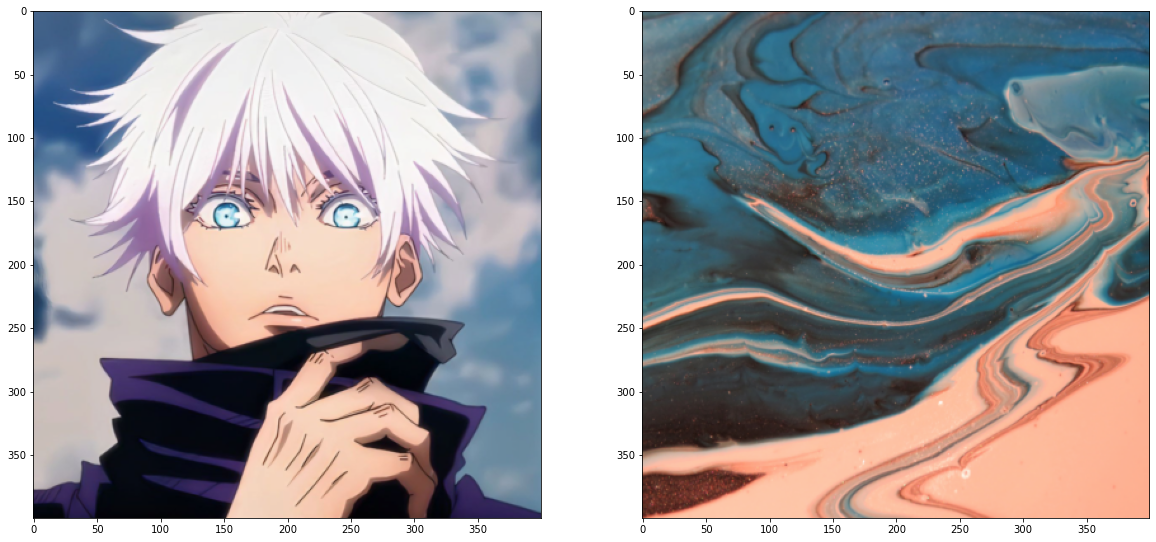

In [7]:
figure, (img1, img2) = plt.subplots(1, 2, figsize=(20, 10))
img1.imshow(Conv_IMG(contentImage))
img2.imshow(Conv_IMG(styleImage))

### Content and Style Features

In [8]:
def IMGFeatures(img, model, l=None):
    if l is None:
        l = {'0': 'conv1_1',
                 '5': 'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}
        
    F = {}
    x = img
    for name, layer in model._modules.items():
        x = layer(x)
        if name in l:
            F[l[name]] = x
            
    return F

### Gram Matrix

In [9]:
def GM(tensor):
    _, a, b, c = tensor.size()
    
    tensor = tensor.view(a, b*c)
    
    GMT = torch.mm(tensor, tensor.t())
    
    return GMT

### Calculate Features

In [10]:
content_FT = IMGFeatures(contentImage, VGG_MODEL)
style_FT = IMGFeatures(styleImage, VGG_MODEL)

style_GM = {layer: GM(style_FT[layer]) for layer in style_FT}

target = contentImage.clone().requires_grad_(True).to(DT)

### Weights

In [11]:
style_weights = {'conv1_1': 1.,
                'conv2_1': 0.75,
                'conv3_1': 0.2,
                'conv4_1': 0.2,
                'conv5_1': 0.2}

C_W = 1
S_W = 1e6

### Updating the Target & Calculating Losses

10000 iteration 
##### Content Loss
##### Style Loss
##### Total Loss

Total loss:  2474259.5


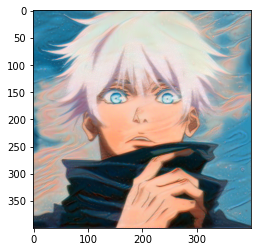

Total loss:  950874.75


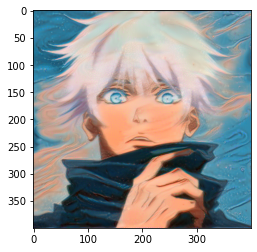

Total loss:  504346.90625


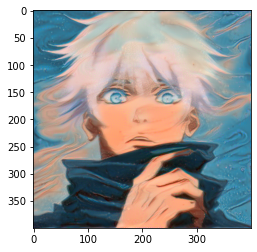

Total loss:  306960.09375


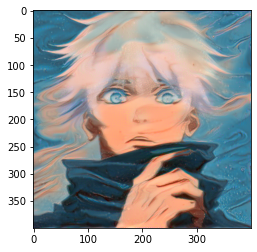

Total loss:  199564.984375


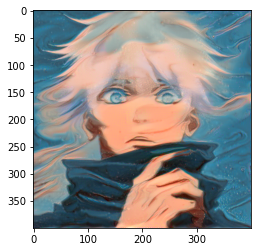

Total loss:  135422.15625


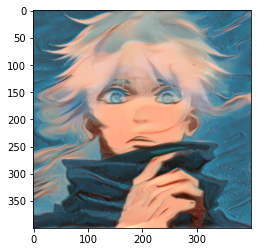

Total loss:  98658.8515625


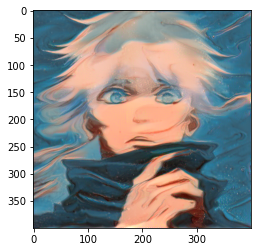

Total loss:  78412.359375


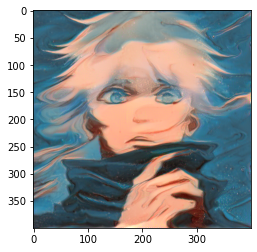

Total loss:  66687.8984375


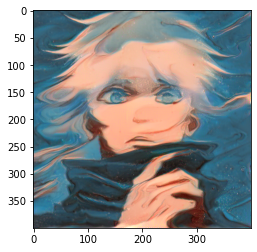

Total loss:  58985.62890625


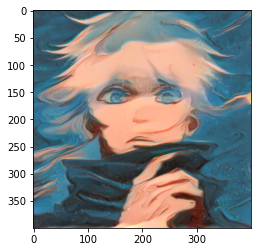

In [12]:
SE = 1000

optimizer = optim.Adam([target], lr=0.003)
iterations = 10000

for k in range(1, iterations+1):
    target_FT = IMGFeatures(target, VGG_MODEL)
    content_loss = torch.mean((target_FT['conv4_2'] - content_FT['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_FT[layer]
        _, a, b, c = target_feature.shape
        
        target_GM = GM(target_feature)
        
        style_GMS = style_GM[layer]
        L_style_loss = style_weights[layer] * torch.mean((target_GM - style_GMS)**2)
        
        style_loss += L_style_loss / (a * b * c)
    
    total_loss = C_W * content_loss + S_W * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if k % SE == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(Conv_IMG(target))
        plt.show()

### Display the Results

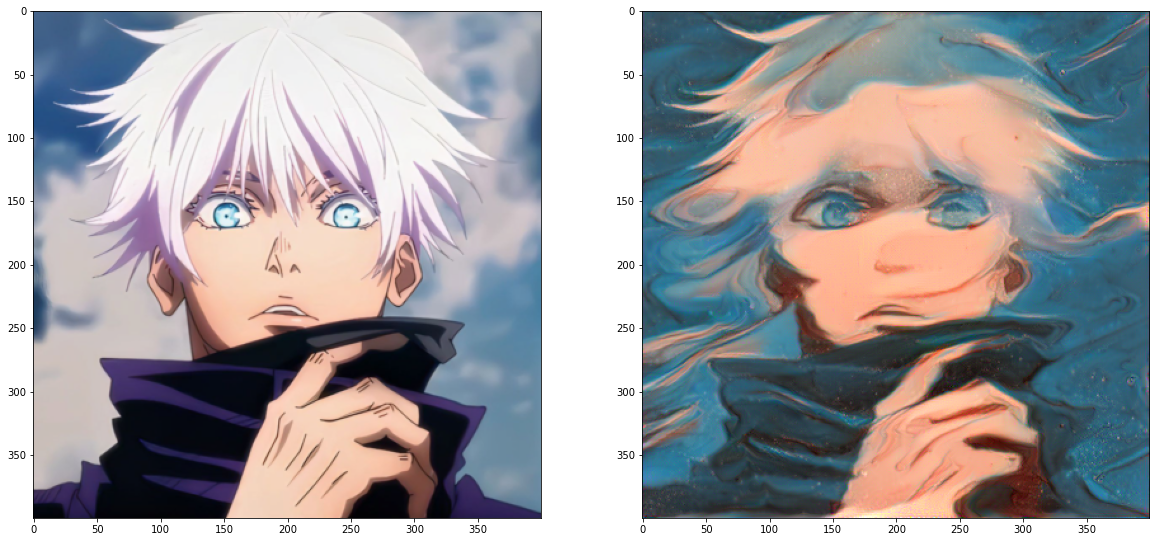

In [13]:
figure, (img1, img2) = plt.subplots(1, 2, figsize=(20, 10))
img1.imshow(Conv_IMG(contentImage))

img2.imshow(Conv_IMG(target))
plt.savefig("Result.png")


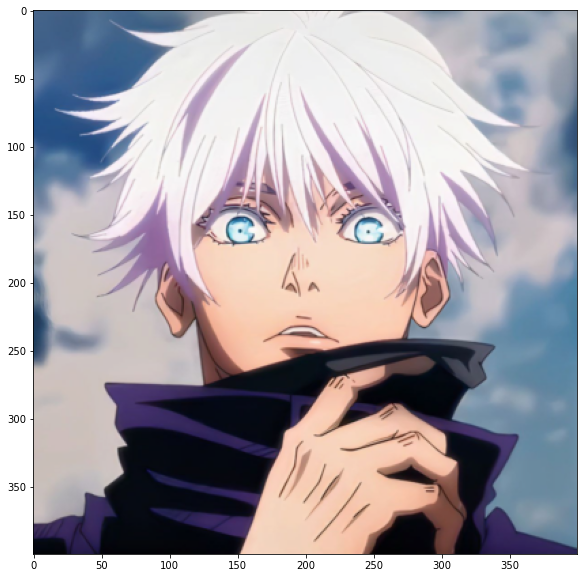

In [14]:
figure, (img1) = plt.subplots(1, figsize=(20, 10))
img1.imshow(Conv_IMG(contentImage))
plt.savefig("Content image only .png")

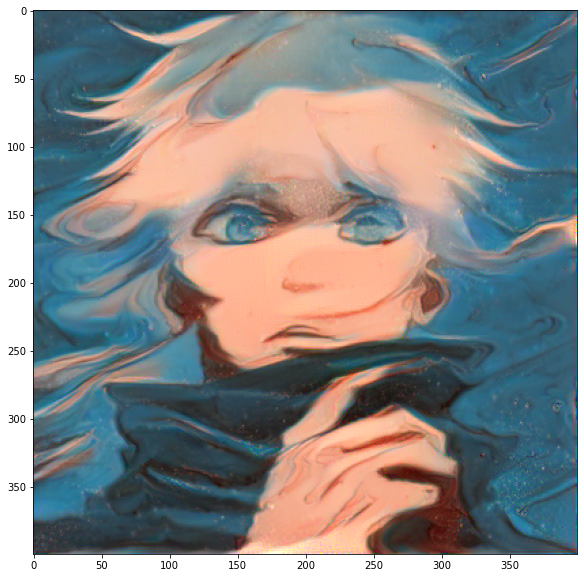

In [15]:
figure, (img2) = plt.subplots(1, figsize=(20, 10))
img2.imshow(Conv_IMG(target))
plt.savefig("Only result.png")